**RNN time series forecast**


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

**Generate a series to evaluate various models**

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):  # Adds a trend to a series
    return slope * time

def seasonal_pattern(season_time):  # Defines a cycle
        return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):  # Adds a recuring cycle to a series
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):  # Adds noice to a series
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

**Create series with trend, recurring pattern, and noise**


series shape:  (1461,)
first window:
 [60.       59.938343 59.743538 59.416134 58.957005 58.367393 57.648876
 56.8034   55.833214 54.74093  53.52947  52.202076 50.762306 49.214005
 47.56132  45.808666 43.96073  42.02247  39.999043 37.895866]


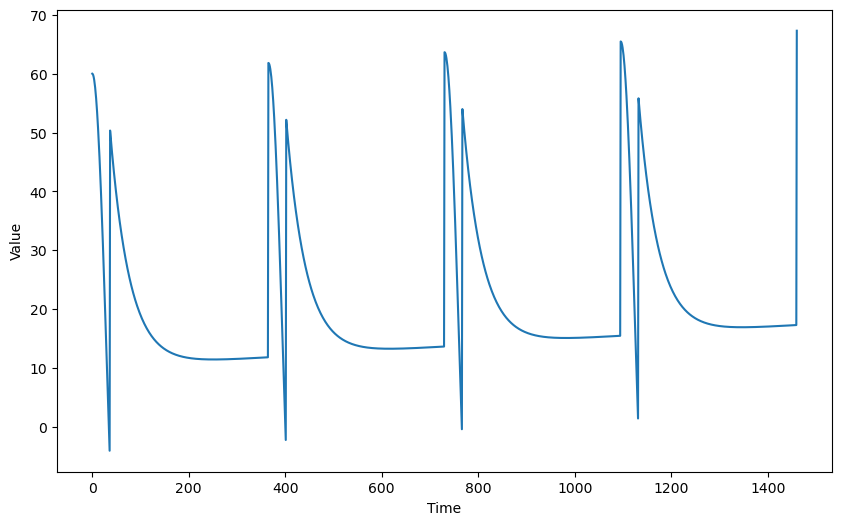

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 0
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    
print ('series shape: ',np.shape(G.SERIES))
print('first window:\n',G.SERIES[0:20])
    
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Do Train / Validation split**


In [47]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

print('series_train:',series_train.shape)
print('series_valid:', series_valid.shape)

series_train: (1100,)
series_valid: (361,)


**Create TF sliding window dataset**

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

for element in dataset:
    print ('dataset is:   ',type(dataset))
    print ('              ',  dataset)
    print ('\nelement is:   ',type(element))
    print ('element[0] is:',np.shape(element[0]))
    print('\nfirst element[0][0]:\n',element[0][0])

    break


dataset is:    <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
               <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

element is:    <class 'tuple'>
element[0] is: (32, 20)

first element[0][0]:
 tf.Tensor(
[60.       59.938343 59.743538 59.416134 58.957005 58.367393 57.648876
 56.8034   55.833214 54.74093  53.52947  52.202076 50.762306 49.214005
 47.56132  45.808666 43.96073  42.02247  39.999043 37.895866], shape=(20,), dtype=float32)


**Create model**

In [6]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    return model

In [7]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

result=uncompiled_model.predict(dataset)
print(type(result))
print(result.shape)  #train lenght minus window

<class 'numpy.ndarray'>
(1080, 1)


**Use Learning Rate Scheduler to try out a range of learning rates


In [3]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5,momentum=.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [20]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 6s 14ms/step - loss: 8.1089 - mae: 8.5668
Epoch 2/100
34/34 [==============================] - 0s 11ms/step - loss: 7.1312 - mae: 7.6106
Epoch 3/100
34/34 [==============================] - 0s 11ms/step - loss: 6.8986 - mae: 7.3666
Epoch 4/100
34/34 [==============================] - 0s 11ms/step - loss: 6.8525 - mae: 7.3267
Epoch 5/100
34/34 [==============================] - 0s 11ms/step - loss: 6.7731 - mae: 7.2469
Epoch 6/100
34/34 [==============================] - 0s 12ms/step - loss: 6.7165 - mae: 7.1914
Epoch 7/100
34/34 [==============================] - 0s 11ms/step - loss: 6.6301 - mae: 7.1052
Epoch 8/100
34/34 [==============================] - 0s 11ms/step - loss: 6.5178 - mae: 6.9849
Epoch 9/100
34/34 [==============================] - 0s 11ms/step - loss: 6.2528 - mae: 6.7211
Epoch 10/100
34/34 [==============================] - 0s 11ms/step - loss: 5.7480 - mae: 6.1737
Epoch 11/100
34/34 [=============================

(1e-07, 1.0, 0.0, 30.0)

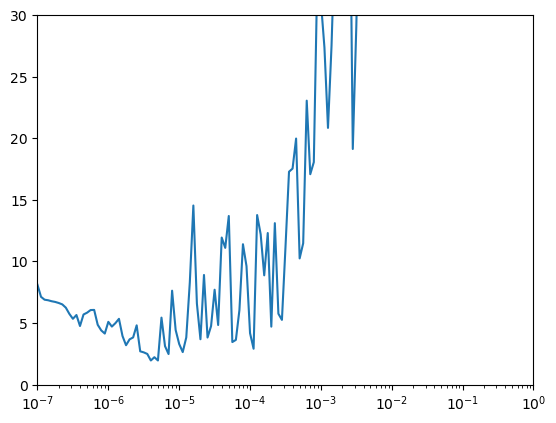

In [49]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-7, 1, 0, 30])


## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [22]:
def create_model():

    tf.random.set_seed(51)
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=5e-6,momentum=.9), 
                  metrics=["mae"])   

    return model

In [35]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50, verbose=0)

Epoch 1/50
34/34 - 6s - loss: 19.2415 - mae: 19.7303
Epoch 2/50
34/34 - 0s - loss: 7.3033 - mae: 7.7823
Epoch 3/50
34/34 - 0s - loss: 5.4621 - mae: 5.9411
Epoch 4/50
34/34 - 0s - loss: 4.3666 - mae: 4.8451
Epoch 5/50
34/34 - 0s - loss: 4.3522 - mae: 4.8220
Epoch 6/50
34/34 - 0s - loss: 4.1738 - mae: 4.6524
Epoch 7/50
34/34 - 0s - loss: 4.5908 - mae: 5.0730
Epoch 8/50
34/34 - 0s - loss: 3.4885 - mae: 3.9645
Epoch 9/50
34/34 - 0s - loss: 4.3304 - mae: 4.8119
Epoch 10/50
34/34 - 0s - loss: 2.7549 - mae: 3.2147
Epoch 11/50
34/34 - 0s - loss: 2.1748 - mae: 2.6141
Epoch 12/50
34/34 - 0s - loss: 1.9181 - mae: 2.3189
Epoch 13/50
34/34 - 0s - loss: 1.8826 - mae: 2.3042
Epoch 14/50
34/34 - 0s - loss: 1.9034 - mae: 2.3346
Epoch 15/50
34/34 - 0s - loss: 1.9192 - mae: 2.3503
Epoch 16/50
34/34 - 0s - loss: 2.1148 - mae: 2.5715
Epoch 17/50
34/34 - 0s - loss: 1.6610 - mae: 2.0412
Epoch 18/50
34/34 - 0s - loss: 2.0535 - mae: 2.4688
Epoch 19/50
34/34 - 0s - loss: 2.2233 - mae: 2.6741
Epoch 20/50
34/34 -

**Evaluate the forecast**


In [24]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<class 'numpy.ndarray'> (1442, 1)
<class 'numpy.ndarray'> (1442,)
<class 'numpy.ndarray'> (361,)


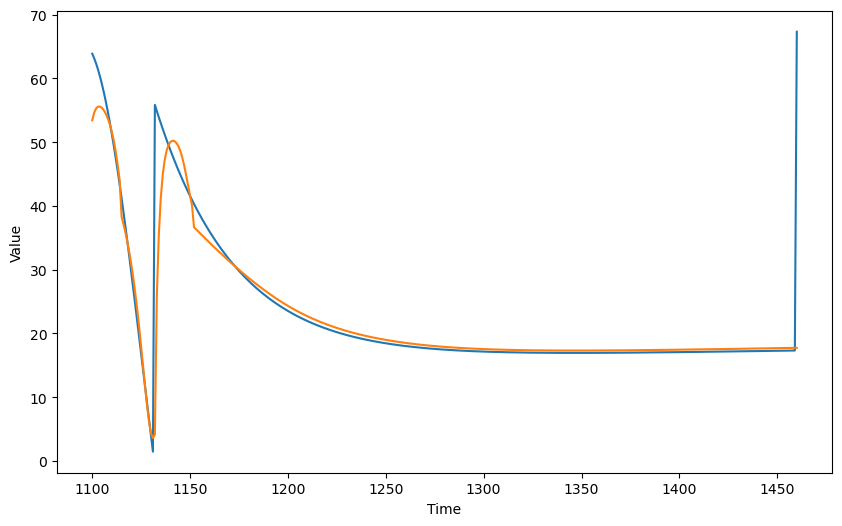

In [48]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE)
print (type(rnn_forecast),np.shape(rnn_forecast))
rnn_forecast=rnn_forecast.squeeze()
print (type(rnn_forecast),np.shape(rnn_forecast))


# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
print (type(rnn_forecast),np.shape(rnn_forecast))
# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)  
plot_series(time_valid, rnn_forecast)

**Compute MSE and MAE**

In [45]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse={mse:.2f}    mae={mae:.2f}")

mse=19.65    mae=1.21


**Save the model**

In [46]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
tar: : Couldn't visit directory: No such file or directory
tar: Error exit delayed from previous errors.
